<div class="alert alert-block alert-success">
    <b>ARTIFICIAL INTELLIGENCE (E016350A)</b> <br>
ALEKSANDRA PIZURICA <br>
GHENT UNIVERSITY <br>
AY 2024/2025 <br>
Assistant: Nicolas Vercheval
</div>

# Convolutional neural networks (CNN) - image classification (part 2)

In this example, we will create a classifier to classify cats and dogs. We will show how we can artificially increase the set of available data using the `tf.keras.preprocessing.image.ImageDataGenerator` functionality offered by keras. We will also show the dropout regularization.

## Loading packages

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Loading data

We will use the <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> dataset from the Kaggle platform. 

Instead of using `tf.keras.utils.get_file`, you can also download the file manually,
place it somewhere on the disk, and update the paths to point to it.

In [ ]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

The dataset has the following structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We define the necessary paths to the training and validation datasets, and classes within them.

In [ ]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats') 
train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Understanding the data

Let's look at basic information about the dataset, such as the number of instances per class and the image resolution.

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [ ]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

The use of constants in the code should be avoided so we can define the variables that we will use in the future.

In [ ]:
batch_size = 128
epochs = 20
img_height = img_width = 150

## Preparing the data

To pass images to the network, it is necessary to load them and transform them into tensors.

To facilitate this process, we can use the `ImageDataGenerator` class offered by` tf.keras`. It offers the functionality of reading images from disk and applying defined preprocessing steps, resulting in a tensor that can be passed to the network.

The next part constructs `ImageDataGenerator` generators for our data set. We define `rescale=1./255`, whose generator will multiply each image pixel by $\frac{1}{255}$.

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

The `flow_from_directory` function loads images from disk, applies scaling, and scales images to the required size (user-defined). The result of the function is an iterator that we can use to get `batch_size` images over each iterator call.

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary')

In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary')

### Visualization of images

Let us now visualize some of the images.

In [ ]:
sample_training_images, sample_training_labels = next(train_data_gen)

In [ ]:
np.unique(sample_training_labels)

The function `next` (inside of python standard library) returns the first mini-batch. The return value is in the form `(x_train, y_train)`.

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(sample_training_images[:5])

## Defining the model

Similar to the previous example, we will make several layers consisting of convolution-pooling pairs. After that, we will add a `Flatten` layer to transfer everything to a vector forwarded to the binary classifier.

In fact, instead of 1 neuron, in the end, we can use two (as in previous examples with more classes), but there is no need for that. In practice, a single neuron is often used, and its activation is observed. We will choose a sigmoid activation function because it resembles a probability function.

In [ ]:
model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compiling the model

For this tutorial, choose the *ADAM* optimizer and the *binary cross entropy* loss function. Pass the `metrics` argument to view training and validation accuracy for each training epoch.

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

### Model summary

In [ ]:
model

In [ ]:
model.summary()

### Training the model

Since our data is not loaded into working memory as in the previous example, but we use a generator that loads it if necessary, we will use the `fit_generator` function, which expects to be passed a generator that will be able to access the necessary data when training the network.

In [ ]:
print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

In [ ]:
history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

### Summary of the network training

Let us visualize the results.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can notice that the error at the validation set started to grow after about ten epochs and that the accuracy started to deviate drastically from the training set. This is a clear sign that there is overfitting. This is expected given the complexity of our model and the number of instances in the data set available.

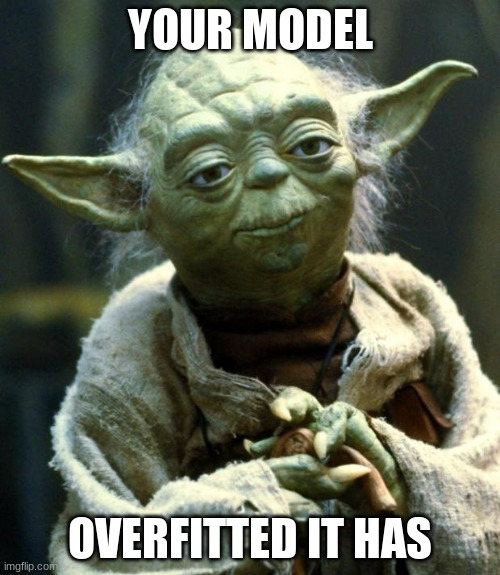

## Data augmentation

We can alleviate the problem of small amounts of data by being able to generate more data based on existing ones using some defined transformations.

`ImageDataGenerator` provides support for this with a relatively simple interface to use.

### Augmentation and visualization of data

Before we define the transformations and let the model train, let's look at how `ImageDataGenerator` works.

For example, let’s add a horizontal flip.

### Horizontal flip

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(img_height, img_width))

We will take one picture from the set and repeat it 5 times to notice
how the transformation we have defined is maintained.

In [ ]:
augmented_images = (train_data_gen[0][0][0] for i in range(5))

In [ ]:
plotImages(augmented_images)

### Rotation of the images

We can add random image rotation in the interval $[-45, 45]$.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(img_height, img_width))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [ ]:
plotImages(augmented_images)

### Zooming the image

A transformation that adds zoom over the image can also be applied.

In [ ]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) 

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(img_height, img_width))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [ ]:
plotImages(augmented_images)

### Defining a couple of transformations

We will now apply a few transformations and prepare an image generator.

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(img_height, img_width),
                                                     class_mode='binary')

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating validation generator

We don't want to add any transformations over the validation images (why?), so the validation image generator will practically remain as it was in the previous example.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(img_height, img_width),
                                                 class_mode='binary')

## Dropout

The dropout regularization can improve the neural network's generalization. The idea is to randomly zero neurons, enabling different data flows through the network instead of relying too much on only one.

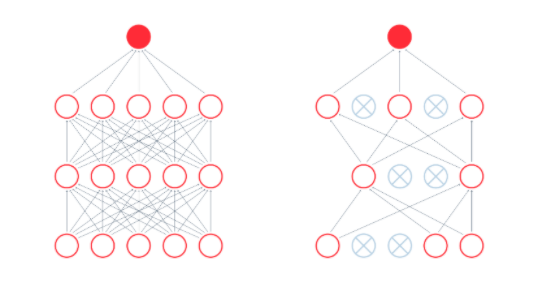

Add the `Dropout` layer to the network to apply this technique. Its parameter is the probability of switching off individual neurons.

Dropout is defined over the layer by setting a parameter between 0 and 1. If we set its parameter to $0.1$, about $10%$ of neural units will be randomly selected and set to zero during training. This way, those neurons won't propagate anything to the rest of the network.

A deterministic relation between inputs and outputs may be easy to memorize if the network has a lot of parameters and may cause overfitting. Dropout forces the network to detect and evaluate different patterns and to rely more on estimation than memory. Hence, the network learns to generalize more. Note that the dropout will not affect the network during evaluation.

More information about the dropout can be found [here](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/).

## Defining a new network which has a Dropout

We will set the dropout after the convolution and pooling pairs with a value of 0.2.

In [ ]:
model_new = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.1),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.1),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compiling the model

In [ ]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

model_new.summary()

### Training the model

After the changes we introduced, it is finally time to retrain the model!

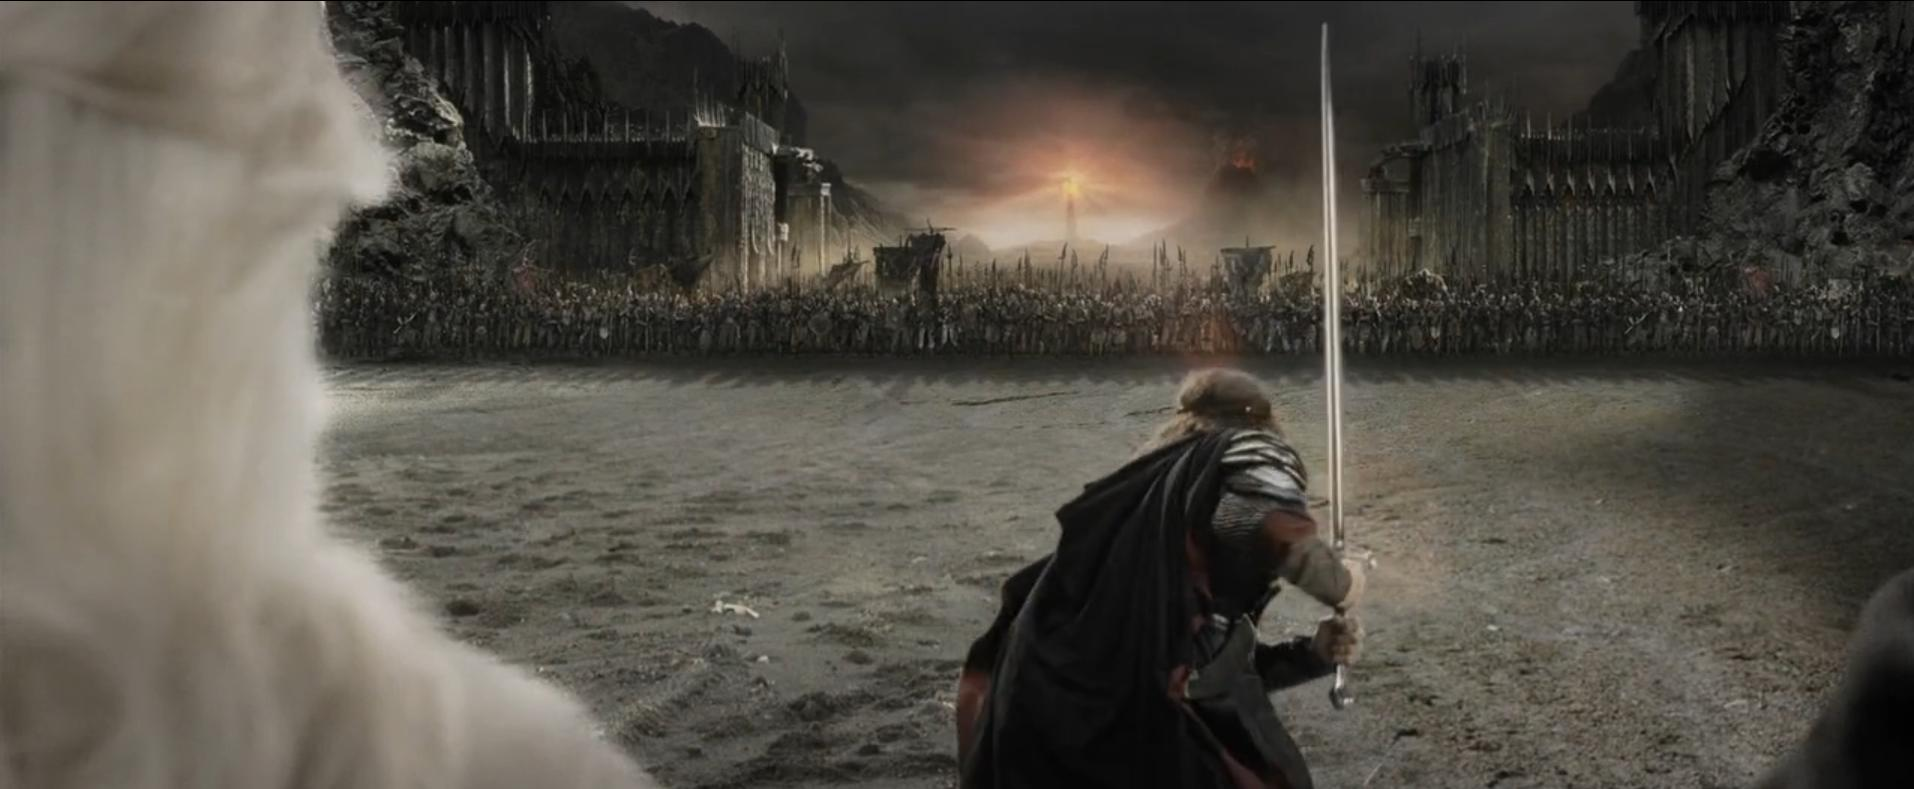

In [ ]:
history = model_new.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

### Model evaluation

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We notice that the model is much better than the last attempt! Now that the overfitting is reduced, we can consider increasing the number of epochs and using `EarlyStopping` to see how much the model can learn.

<div class='alert alert-info'>
    For further reading:
    <a href='https://cs231n.github.io/convolutional-networks/'> CNN for visual recognition </a>
</div>